## Simple single node graph

In [1]:
from pydantic import BaseModel, Field

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode

from langchain_core.messages import AIMessage, ToolMessage

from jinja2 import Template
from typing import Literal, Dict, Any, Annotated, List
from IPython.display import Image, display
from operator import add
from openai import OpenAI

import random
import ast
import inspect
import instructor
import json

In [2]:
class State(BaseModel):
    message: str
    answer: str = ""
    vibe: str

In [3]:
def append_vibes_to_query(state: State) -> dict:

    return {"answer": f"{state.message} {state.vibe}"}

In [4]:
workflow = StateGraph(State)

workflow.add_node("append_vibes_to_query", append_vibes_to_query)
workflow.add_edge(START, "append_vibes_to_query")
workflow.add_edge("append_vibes_to_query", END)

graph = workflow.compile()

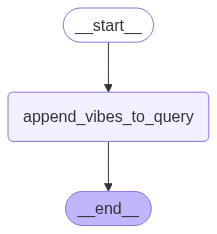

In [5]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
initial_state = {
    "message": "Give me some vibes!",
    "vibe": "I'm feelinga like a badass today!"
}

In [7]:
result = graph.invoke(initial_state)

In [8]:
result

{'message': 'Give me some vibes!',
 'answer': "Give me some vibes! I'm feelinga like a badass today!",
 'vibe': "I'm feelinga like a badass today!"}

### Conditional graph

In [9]:
class State(BaseModel):
    message: str
    answer: str = ""

In [10]:
def append_vibes_to_query(state: State) -> dict:

    return {"answer": "I am here to add some vibes!"}

In [11]:
def router(state: State) -> Literal["append_vibe_1", "append_vibe_2", "append_vibe_3"]:
    
    vibes = ["append_vibe_1", "append_vibe_2", "append_vibe_3"]

    vibe_path = random.choice(vibes)

    return vibe_path

In [12]:
def append_vibe_1(state: State) -> dict:
    vibe = "I'm feeling like a badass today!"

    return{"answer": f"{state.answer} {state.message} {vibe}"}

def append_vibe_2(state: State) -> dict:
    vibe = "I'm feeling like a boss today!"

    return{"answer": f"{state.answer} {state.message} {vibe}"}

def append_vibe_3(state: State) -> dict:
    vibe = "I'm feeling like a legend today!"

    return{"answer": f"{state.answer} {state.message} {vibe}"}

In [13]:
workflow = StateGraph(State)

workflow.add_node("append_vibes_to_query", append_vibes_to_query)
workflow.add_node("append_vibe_1", append_vibe_1)
workflow.add_node("append_vibe_2", append_vibe_2)
workflow.add_node("append_vibe_3", append_vibe_3)

workflow.add_edge(START, "append_vibes_to_query")

workflow.add_conditional_edges(
    "append_vibes_to_query",
     router,
     )

workflow.add_edge("append_vibe_1", END)
workflow.add_edge("append_vibe_2", END)
workflow.add_edge("append_vibe_3", END)

graph = workflow.compile()

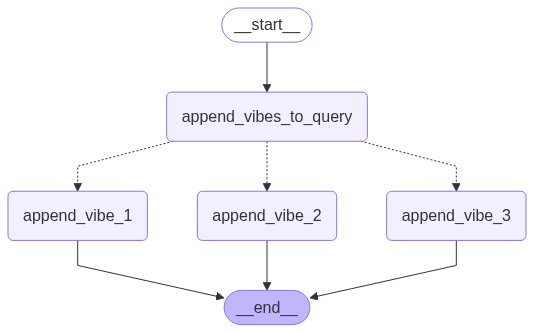

In [14]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
initial_state = {
    "message": "Give me some vibes!"
}

result = graph.invoke(initial_state)

In [16]:
result

{'message': 'Give me some vibes!',
 'answer': "I am here to add some vibes! Give me some vibes! I'm feeling like a legend today!"}

### Agent graph

In [17]:
def append_vibes(query: str, vibe: str) -> str:
    """
    It takes in a query and a vibe and returns a string with the query and vibe appended.
    
    Args:
        query: The query to append the vibe to.
        vibe: The vibe to append to the query.

    Returns:
        A string with the query and vibe appended.
    """


    print(f"{query} {vibe}")
    return f"{query} {vibe}"

In [18]:
def parse_function_definition(function_def: str) -> Dict[str, Any]:
    """Parse a function definition string to extract metadata including type hints."""
    result = {
        "name": "",
        "description": "",
        "parameters": {"type": "object", "properties": {}},
        "required": [],
        "returns": {"type": "string", "description": ""}
    }
    
    # Parse the function using AST
    tree = ast.parse(function_def.strip())
    if not tree.body or not isinstance(tree.body[0], ast.FunctionDef):
        return result
        
    func = tree.body[0]
    result["name"] = func.name
    
    # Extract docstring
    docstring = ast.get_docstring(func) or ""
    if docstring:
        # Extract description (first line/paragraph)
        desc_end = docstring.find('\n\n') if '\n\n' in docstring else docstring.find('\nArgs:')
        desc_end = desc_end if desc_end > 0 else docstring.find('\nParameters:')
        result["description"] = docstring[:desc_end].strip() if desc_end > 0 else docstring.strip()
        
        # Parse parameter descriptions
        param_descs = parse_docstring_params(docstring)
        
        # Extract return description
        if "Returns:" in docstring:
            result["returns"]["description"] = docstring.split("Returns:")[1].strip().split('\n')[0]
    
    # Extract parameters with type hints
    args = func.args
    defaults = args.defaults
    num_args = len(args.args)
    num_defaults = len(defaults)
    
    for i, arg in enumerate(args.args):
        if arg.arg == 'self':
            continue
            
        param_info = {
            "type": get_type_from_annotation(arg.annotation) if arg.annotation else "string",
            "description": param_descs.get(arg.arg, "")
        }
        
        # Check for default value
        default_idx = i - (num_args - num_defaults)
        if default_idx >= 0:
            param_info["default"] = ast.literal_eval(ast.unparse(defaults[default_idx]))
        else:
            result["required"].append(arg.arg)
        
        result["parameters"]["properties"][arg.arg] = param_info
    
    # Extract return type
    if func.returns:
        result["returns"]["type"] = get_type_from_annotation(func.returns)
    
    return result


def get_type_from_annotation(annotation) -> str:
    """Convert AST annotation to type string."""
    if not annotation:
        return "string"
    
    type_map = {
        'str': 'string',
        'int': 'integer', 
        'float': 'number',
        'bool': 'boolean',
        'list': 'array',
        'dict': 'object',
        'List': 'array',
        'Dict': 'object'
    }
    
    if isinstance(annotation, ast.Name):
        return type_map.get(annotation.id, annotation.id)
    elif isinstance(annotation, ast.Subscript) and isinstance(annotation.value, ast.Name):
        base_type = annotation.value.id
        return type_map.get(base_type, base_type.lower())
    
    return "string"


def parse_docstring_params(docstring: str) -> Dict[str, str]:
    """Extract parameter descriptions from docstring (handles both Args: and Parameters: formats)."""
    params = {}
    lines = docstring.split('\n')
    in_params = False
    current_param = None
    
    for line in lines:
        stripped = line.strip()
        
        # Check for parameter section start
        if stripped in ['Args:', 'Arguments:', 'Parameters:', 'Params:']:
            in_params = True
            current_param = None
        elif stripped.startswith('Returns:') or stripped.startswith('Raises:'):
            in_params = False
        elif in_params:
            # Parse parameter line (handles "param: desc" and "- param: desc" formats)
            if ':' in stripped and (stripped[0].isalpha() or stripped.startswith(('-', '*'))):
                param_name = stripped.lstrip('- *').split(':')[0].strip()
                param_desc = ':'.join(stripped.lstrip('- *').split(':')[1:]).strip()
                params[param_name] = param_desc
                current_param = param_name
            elif current_param and stripped:
                # Continuation of previous parameter description
                params[current_param] += ' ' + stripped
    
    return params

In [19]:
def get_tool_descriptions_from_node(tool_node):
    """Extract tool descriptions from the ToolNode object."""
    descriptions = []
    
    if hasattr(tool_node, 'tools_by_name'):
        tools_by_name = tool_node.tools_by_name
        
        for tool_name, tool in tools_by_name.items():
            function_string = inspect.getsource(globals()[tool_name])
            # function_string = inspect.getsource(getattr(tool_name))
            result = parse_function_definition(function_string)

            if result:
                descriptions.append(result)
    
    return descriptions if descriptions else "Could not extract tool descriptions"

In [20]:
function_string = inspect.getsource(globals()["append_vibes"])

In [21]:
print(function_string)

def append_vibes(query: str, vibe: str) -> str:
    """
    It takes in a query and a vibe and returns a string with the query and vibe appended.

    Args:
        query: The query to append the vibe to.
        vibe: The vibe to append to the query.

    Returns:
        A string with the query and vibe appended.
    """


    print(f"{query} {vibe}")
    return f"{query} {vibe}"



In [22]:
result = parse_function_definition(function_string)

In [23]:
result

{'name': 'append_vibes',
 'description': 'It takes in a query and a vibe and returns a string with the query and vibe appended.',
 'parameters': {'type': 'object',
  'properties': {'query': {'type': 'string',
    'description': 'The query to append the vibe to.'},
   'vibe': {'type': 'string',
    'description': 'The vibe to append to the query.'}}},
 'required': ['query', 'vibe'],
 'returns': {'type': 'string',
  'description': 'A string with the query and vibe appended.'}}

In [24]:
class ToolCall(BaseModel):
    name: str
    arguments: dict

class AgentResponse(BaseModel):
    answer: str
    tool_calls: List[ToolCall] = Field(default_factory=list)

class State(BaseModel):
    messages: Annotated[List[Any], add] = []
    message: str = ""
    iteration: int = Field(default=0)
    answer: str = ""
    available_tools: List[Dict[str, Any]] = []
    tool_calls: List[ToolCall] = Field(default_factory=list)

In [25]:
def agent_node(state: State) -> dict:

   prompt_template =  """You are a assistant that is generating vibes for a user.

You will be given a selection of tools you can use to add vibes to a user's query.

<Available tools>
{{ available_tools | tojson }}
</Available tools>

When you need to use a tool, format your response as:

<tool_call>
{"name": "tool_name", "arguments": {...}}
</tool_call>

Instructions:
- You need to use the tools to add vibes to the user's query.
- Add a random vibe to the user's query.
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      available_tools=state.available_tools
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=AgentResponse,
        messages=[{"role": "system", "content": prompt}, {"role": "user", "content": state.message}],
        temperature=0.5,
   )

   if response.tool_calls:
      tool_calls = []
      for i, tc in enumerate(response.tool_calls):
         tool_calls.append({
               "id": f"call_{i}",
               "name": tc.name,
               "args": tc.arguments
         })

      ai_message = AIMessage(
         content=response.answer,
         tool_calls=tool_calls
         )
   else:
      ai_message = AIMessage(
         content=response.answer,
      )

   return {
      "messages": [ai_message],
      "tool_calls": response.tool_calls
   }

In [26]:
def tool_router(state: State) -> str:
    """
    Determines whether the workflow should continue or end"""

    if len(state.tool_calls) > 0:
        return "tools"
    else:
        return "end"

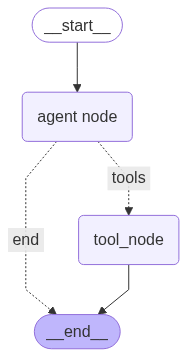

In [27]:
workflow = StateGraph(State)

tools = [append_vibes]
tool_node = ToolNode(tools)

tool_descriptions = get_tool_descriptions_from_node(tool_node)

workflow.add_node("agent node", agent_node)
workflow.add_node("tool_node", tool_node)

workflow.add_edge(START, "agent node")
workflow.add_conditional_edges(
    "agent node", 
    tool_router,
    {
        "tools": "tool_node", 
        "end": END
    }
)

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [28]:
tool_descriptions

[{'name': 'append_vibes',
  'description': 'It takes in a query and a vibe and returns a string with the query and vibe appended.',
  'parameters': {'type': 'object',
   'properties': {'query': {'type': 'string',
     'description': 'The query to append the vibe to.'},
    'vibe': {'type': 'string',
     'description': 'The vibe to append to the query.'}}},
  'required': ['query', 'vibe'],
  'returns': {'type': 'string',
   'description': 'A string with the query and vibe appended.'}}]

In [29]:
initial_state = {
    "message": "Give me some vibes!",
    "available_tools": tool_descriptions
}
result = graph.invoke(initial_state)

Give me some vibes! chill and positive


In [30]:
for data in result["messages"]:
    print(data)

content="Here's a vibe for you!" additional_kwargs={} response_metadata={} tool_calls=[{'name': 'append_vibes', 'args': {'query': 'Give me some vibes!', 'vibe': 'chill and positive'}, 'id': 'call_0', 'type': 'tool_call'}]
content='Give me some vibes! chill and positive' name='append_vibes' tool_call_id='call_0'


## Agent Graph with Loopback from Tools

In [31]:
def append_vibes(query: str, vibe: str) -> str:
    """
    It takes in a query and a vibe and returns a string with the query and vibe appended.
    
    Args:
        query: The query to append the vibe to.
        vibe: The vibe to append to the query.

    Returns:
        A string with the query and vibe appended.
    """


    print(f"{query} {vibe}")
    return f"{query} {vibe}"

In [32]:
class ToolCall(BaseModel):
    name: str
    arguments: dict

class AgentResponse(BaseModel):
    answer: str
    tool_calls: List[ToolCall] = Field(default_factory=list)

class State(BaseModel):
    messages: Annotated[List[Any], add] = []
    message: str = ""
    iteration: int = Field(default=0)
    answer: str = ""
    available_tools: List[Dict[str, Any]] = []
    tool_calls: List[ToolCall] = Field(default_factory=list)

In [33]:
def lc_messages_to_regular_messages(msg):
    """Transforms LangChain messages to OpenAi compatible message format."""

    if isinstance(msg, dict):
        
        if msg.get("role") == "user":
            return {"role": "user", "content": msg["content"]}
        elif msg.get("role") == "assistant":
            return {"role": "assistant", "content": msg["content"]}
        elif msg.get("role") == "tool":
            return {
                "role": "tool", 
                "content": msg["content"], 
                "tool_call_id": msg.get("tool_call_id")
            }
        
    elif isinstance(msg, AIMessage):

        result = {
            "role": "assistant",
            "content": msg.content
        }
        
        if hasattr(msg, 'tool_calls') and msg.tool_calls and len(msg.tool_calls) > 0 and not msg.tool_calls[0].get("name").startswith("functions."):
            result["tool_calls"] = [
                {
                    "id": tc["id"],
                    "type": "function",
                    "function": {
                        "name": tc["name"].replace("functions.", ""),
                        "arguments": json.dumps(tc["args"])
                    }
                }
                for tc in msg.tool_calls
            ]
            
        return result
    
    elif isinstance(msg, ToolMessage):

        return {"role": "tool", "content": msg.content, "tool_call_id": msg.tool_call_id}
    
    else:

        return {"role": "user", "content": str(msg)}

In [ ]:
def agent_node(state: State) -> dict:

   prompt_template =  """You are a assistant that is generating vibes for a user.

You will be given a selection of tools you can use to add vibes to a user's query.

<Available tools>
{{ available_tools | tojson }}
</Available tools>

When you need to use a tool, format your response as:

<tool_call>
{"name": "tool_name", "arguments": {...}}
</tool_call>

Instructions:
- You need to use the tools to add vibes to the user's query.
- Add a random vibe to the user's query.
- Once you have the vibe from the tool, return it as an answer, you can reformulate it a bit.
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      available_tools=state.available_tools
   )

   messages = state.messages

   conversation = []

   for msg in messages:
      conversation.append(lc_messages_to_regular_messages(msg))

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=AgentResponse,
        messages=[{"role": "system", "content": prompt}, *conversation],
        temperature=0.5,
   )

   if response.tool_calls:
      tool_calls = []
      for i, tc in enumerate(response.tool_calls):
         tool_calls.append({
               "id": f"call_{i}",
               "name": tc.name,
               "args": tc.arguments
         })

      ai_message = AIMessage(
         content=response.answer,
         tool_calls=tool_calls
         )
   else:
      ai_message = AIMessage(
         content=response.answer,
      )

   return {
      "messages": [ai_message],
      "tool_calls": response.tool_calls,
      "iteration": state.iteration + 1,
      "answer": response.answer
   }

In [39]:
def tool_router(state: State) -> str:
    """Decide whether to continue or end"""
    
    if state.iteration > 1:
        return "end"
    elif len(state.tool_calls) > 0:
        return "tools"
    else:
        return "end"

In [40]:
workflow = StateGraph(State)

tools = [append_vibes]
tool_node = ToolNode(tools)

tool_descriptions = get_tool_descriptions_from_node(tool_node)

workflow.add_node("agent node", agent_node)
workflow.add_node("tool_node", tool_node)   

workflow.add_edge(START, "agent node")

workflow.add_conditional_edges(
    "agent node", 
    tool_router,
    {
        "tools": "tool_node", 
        "end": END
    }
)

workflow.add_edge("tool_node", "agent node")

graph = workflow.compile()

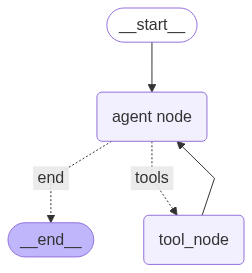

In [41]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [42]:
initial_state = {
    "messages": [{"role": "user", "content": "Give me some vibes!"}],
    "available_tools": tool_descriptions
}
result = graph.invoke(initial_state)

Give me some vibes! chill and upbeat


In [43]:
result

{'messages': [{'role': 'user', 'content': 'Give me some vibes!'},
  AIMessage(content='', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'append_vibes', 'args': {'query': 'Give me some vibes!', 'vibe': 'chill and upbeat'}, 'id': 'call_0', 'type': 'tool_call'}]),
  ToolMessage(content='Give me some vibes! chill and upbeat', name='append_vibes', tool_call_id='call_0'),
  AIMessage(content='Here are some vibes for you: chill and upbeat!', additional_kwargs={}, response_metadata={})],
 'iteration': 2,
 'answer': 'Here are some vibes for you: chill and upbeat!',
 'available_tools': [{'name': 'append_vibes',
   'description': 'It takes in a query and a vibe and returns a string with the query and vibe appended.',
   'parameters': {'type': 'object',
    'properties': {'query': {'type': 'string',
      'description': 'The query to append the vibe to.'},
     'vibe': {'type': 'string',
      'description': 'The vibe to append to the query.'}}},
   'required': ['query', 'vibe']